# Community Detection

Data Source:
https://github.com/benedekrozemberczki/datasets#twitch-social-networks


## Import packages, data and build the graph

In [3]:
# !pip install networkx
# !pip install cdlib

In [4]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from cdlib import algorithms, viz
from networkx.algorithms import community

Note: to be able to use all crisp methods, you need to install some additional packages:  {'karateclub', 'infomap', 'graph_tool', 'leidenalg'}
Note: to be able to use all overlapping methods, you need to install some additional packages:  {'ASLPAw', 'karateclub'}
Note: to be able to use all bipartite methods, you need to install some additional packages:  {'infomap', 'leidenalg'}


In [93]:
# load data
df=pd.read_csv('./ENGB/musae_ENGB_edges.csv')
df.head()

from    to
0  6194   255
1  6194   980
2  6194  2992
3  6194  2507
4  6194   986

In [8]:
%%time
# create Graph
G = nx.from_pandas_edgelist(df, 'from', 'to')

CPU times: user 67.3 ms, sys: 8.35 ms, total: 75.6 ms
Wall time: 73.8 ms


Plot original Network before Community Detection

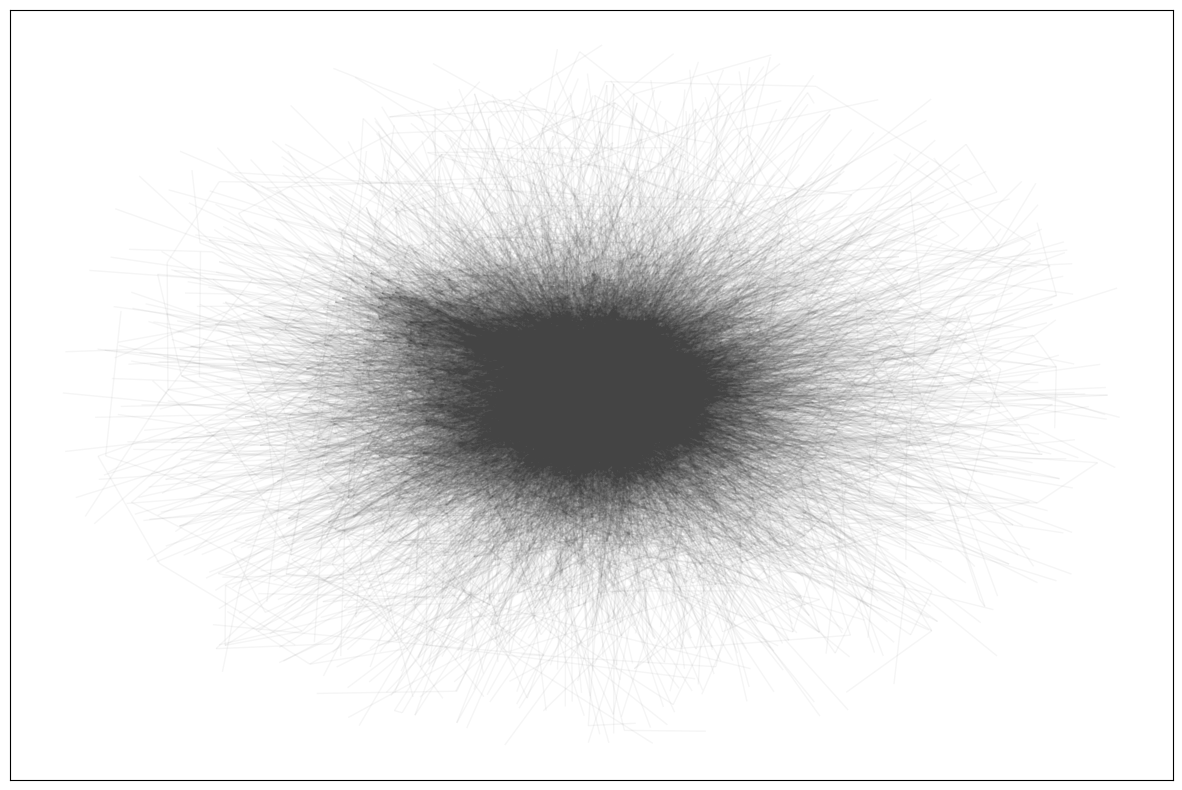

CPU times: user 1min 48s, sys: 28.8 s, total: 2min 16s
Wall time: 1min 38s


In [95]:
%%time
# Plot original Network before Community Detection

# colors = [i/len(G.nodes) for i in range(len(G.nodes))]
# pos = nx.spring_layout(G)
# plt.rcParams.update({'figure.figsize': (15, 15)})
# nx.draw_networkx(G, font_size=16, pos=pos,node_color=colors, edge_color='grey',node_size=10,with_labels=False,width=0.1)
# # nx.draw(G, node_color=color_map,edge_color='grey', with_labels=True)
# plt.show()

pos = nx.spring_layout(G, k=0.1)
plt.style.use('default')
plt.rcParams.update({'figure.figsize': (15, 10)})
nx.draw_networkx(
    G,
    pos=pos,
    node_size=0,
    edge_color="#444444",
    alpha=0.05,
    with_labels=False)
plt.show()


# Community Detection Algorithms for Large Network


Size of the Network:
* 7126 Nodes
* 35324 Edges

Computing Resources:
* Apple Silicon M1 Pro
* Intel(R) Core(TM) i7-6700K CPU @ 4.00GHz   4.01 GHz:  4 cores, 8 threads
* Intel(R) Xeon(R) W-2225 CPU @ 4.10GHz   4.10 GHz:  4 cores, 8 threads

Analyze accuracy and efficiency of different algos on the large Twitch User Network


The transitivity or clustering coefficient of a network is a measure of the tendency of the nodes to cluster together. High transitivity means that the network contains communities or groups of nodes that are densely connected internally.

In [91]:
print("Density: ", nx.density(G))
print("transitivity: ", nx.transitivity(G))
print("Number of nodes : " + str(G.number_of_nodes()))
print("Number of edges : " + str(G.number_of_edges()))

Density:  0.0013914550620165345
transitivity:  0.04243324947984254
Number of nodes : 7126
Number of edges : 35324


In [96]:
# Communities Stats
def communities_stat(comm):
    sizes = [len(i) for i in comm]
    print(f"number of communities: {len(comm)}")
    print(f"average size of communities: {float(sum(sizes)) / len(sizes)}")
    print(f"size of the biggest community: {len(comm[0])}")
    print(f"Total number of nodes in the network: {G.number_of_nodes()}")
    print(f"modularity: {community.modularity(G,comm)}")
    print()

In [97]:
# Communities Visualization Functions
# Reference: https://graphsandnetworks.com/community-detection-using-networkx/
def set_node_community(G, communities):
    '''Add community to node attributes'''
    for c, v_c in enumerate(communities):
        for v in v_c:
            # Add 1 to save 0 for external edges
            G.nodes[v]['community'] = c + 1
            
def set_edge_community(G):
    '''Find internal edges and add their community to their attributes'''
    for v, w, in G.edges:
        if G.nodes[v]['community'] == G.nodes[w]['community']:
            # Internal edge, mark with community
            G.edges[v, w]['community'] = G.nodes[v]['community']
        else:
            # External edge, mark as 0
            G.edges[v, w]['community'] = 0
            
def get_color(i, r_off=1, g_off=1, b_off=1):
    '''Assign a color to a vertex.'''
    r0, g0, b0 = 0, 0, 0
    n = 16
    low, high = 0.1, 0.9
    span = high - low
    r = low + span * (((i + r_off) * 3) % n) / (n - 1)
    g = low + span * (((i + g_off) * 5) % n) / (n - 1)
    b = low + span * (((i + b_off) * 7) % n) / (n - 1)
    return (r, g, b)

def draw_communities(G, communities):
    plt.rcParams.update(plt.rcParamsDefault)
    plt.rcParams.update({'figure.figsize': (15, 10)})
    plt.style.use('dark_background')
    # Set node and edge communities
    set_node_community(G, communities)
    set_edge_community(G)
    # Set community color for internal edges
    external = [(v, w) for v, w in G.edges if G.edges[v, w]['community'] == 0]
    internal = [(v, w) for v, w in G.edges if G.edges[v, w]['community'] > 0]
    internal_color = ["black" for e in internal]
    node_color = [get_color(G.nodes[v]['community']) for v in G.nodes]
    # external edges
    nx.draw_networkx(
        G,
        pos=pos,
        node_size=0,
        edgelist=external,
        edge_color="silver",
        node_color=node_color,
        alpha=0.2,
        with_labels=False)
    # internal edges
    nx.draw_networkx(
        G, pos=pos,
        edgelist=internal,
        edge_color=internal_color,
        node_color=node_color,
        alpha=0.05,
        with_labels=False)
    plt.show()


## Modularity-based communities

The Clauset-Newman-Moore greedy modularity maximization has O(N log^2 N) complexity and found 101 communities in 41.8 s.  The partitions have modularity 0.41 which is the second highest amoung the tested algos.

The naive_greedy_modularity_communities has O(N^4) computational complexity which is much slower than the alternative  and it failed to detect communities in 3 hours.

In [98]:
%%time
greedy_modularity_communities = sorted(community.greedy_modularity_communities(G), key=len, reverse=True)
communities_stat(greedy_modularity_communities)

number of communities: 101
average size of communities: 70.55445544554455
size of the biggest community: 2241
Total number of nodes in the network: 7126
modularity: 0.4194352773646462

CPU times: user 41.6 s, sys: 128 ms, total: 41.7 s
Wall time: 41.8 s


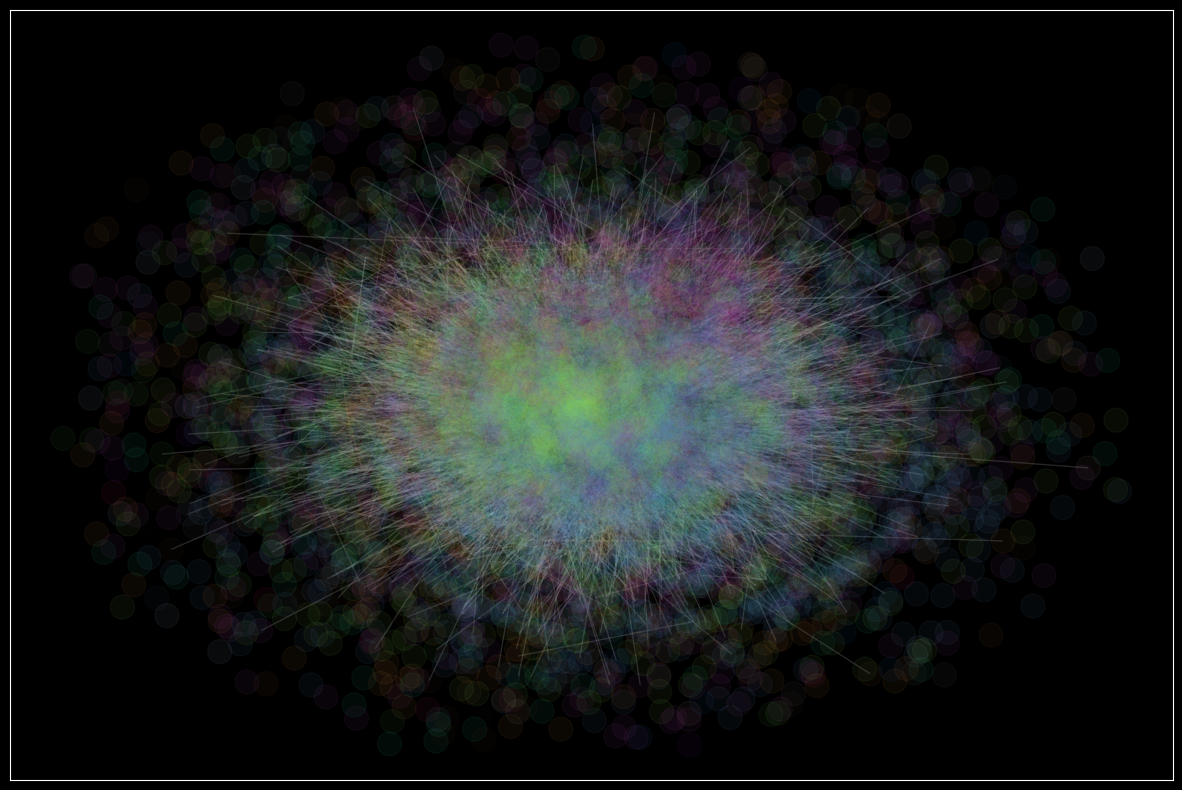

In [43]:
draw_communities(G,greedy_modularity_communities)

naive_greedy_modularity_communities

In [22]:
%%time 
# slow >> 3 hours
# naive_greedy_modularity_communities = sorted(community.naive_greedy_modularity_communities(G), key=len, reverse=True)
# len(naive_greedy_modularity_communities)


## Louvain Community Detection

Louvain is an efficient algo with O(NlogN) computational complexity.

The algo indentified 21 communities in 1.67 s given our computing resources. 

The partitions have modularity 0.45 which is the highest amoung the algos we used. 

In [74]:
%%time
louvain_communities = algorithms.louvain(G, weight='weight', resolution=1., randomize=False)
communities_stat(louvain_communities.communities)

number of communities: 21
average size of communities: 339.3333333333333
size of the biggest community: 1483
Total number of nodes in the network: 7126
modularity: 0.45325161616627774

CPU times: user 1.67 s, sys: 7.57 ms, total: 1.67 s
Wall time: 1.67 s


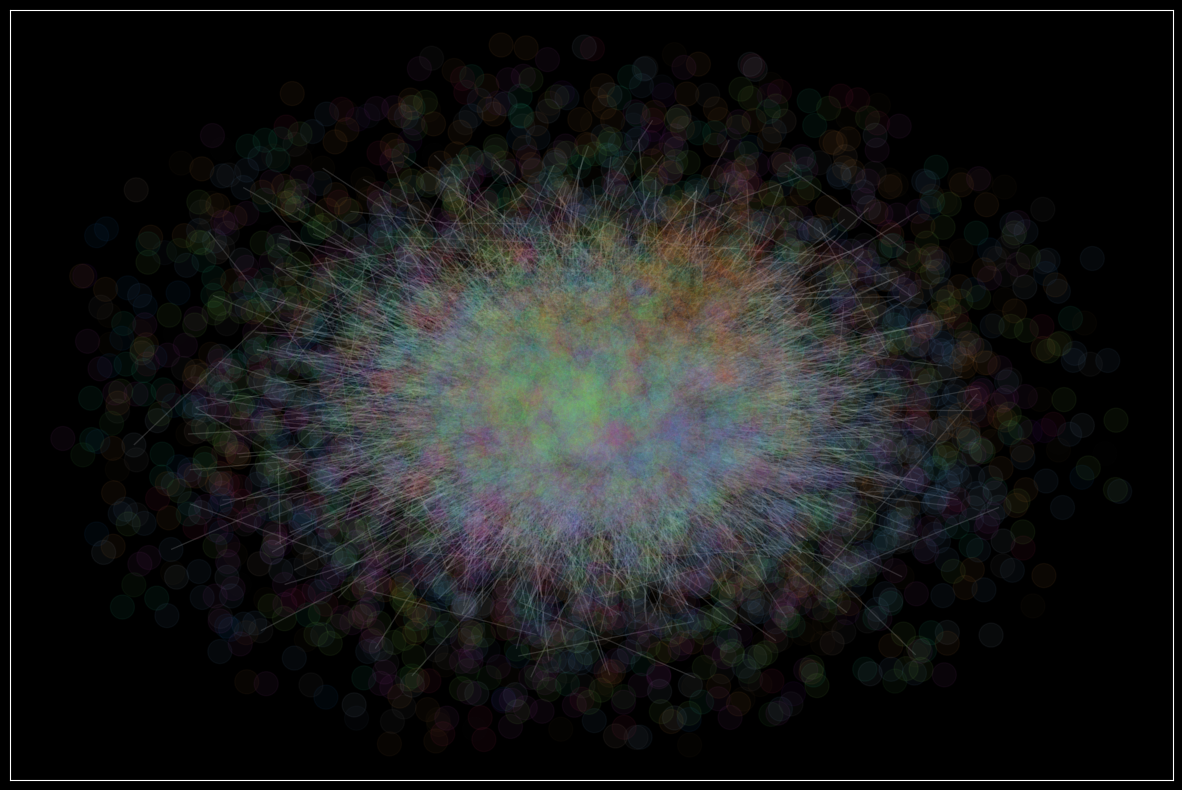

In [75]:
draw_communities(G,louvain_communities.communities)

## Girvan-Newman algorithm
Partitions via centrality measures

The Algo is one of the slowest with high computational complexity O(N^3).

Given our computing resources, the algo failed to find communities in 3 hours.


In [88]:
%%time 
# slow
# %%time
# result = community.girvan_newman(G)
# communities = next(result)
# len(communities)
# slow
# girvan_newman_communities = sorted(community.girvan_newman(G), key=len, reverse=True)

# girvan_newman_communities = algorithms.girvan_newman(G,level=3)
# communities_stat(girvan_newman_communities.communities)


CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 2.86 µs


## Label Propagation
label propagation has significant advantages in its running time. It is the most efficient amoung the algos we tested. 

However, the alog doesn't produce unique solution.  It tends to classify the network (total 7126 nodes) into one big community (e.g. 6352 nodes) and many small communities.  

In [99]:
%%time
label_propagation_communities = sorted(community.label_propagation_communities(G), key=len, reverse=True)
communities_stat(asyn_lpa_communities)

number of communities: 148
average size of communities: 48.148648648648646
size of the biggest community: 6352
Total number of nodes in the network: 7126
modularity: 0.11271385751963052

CPU times: user 391 ms, sys: 4.83 ms, total: 395 ms
Wall time: 395 ms


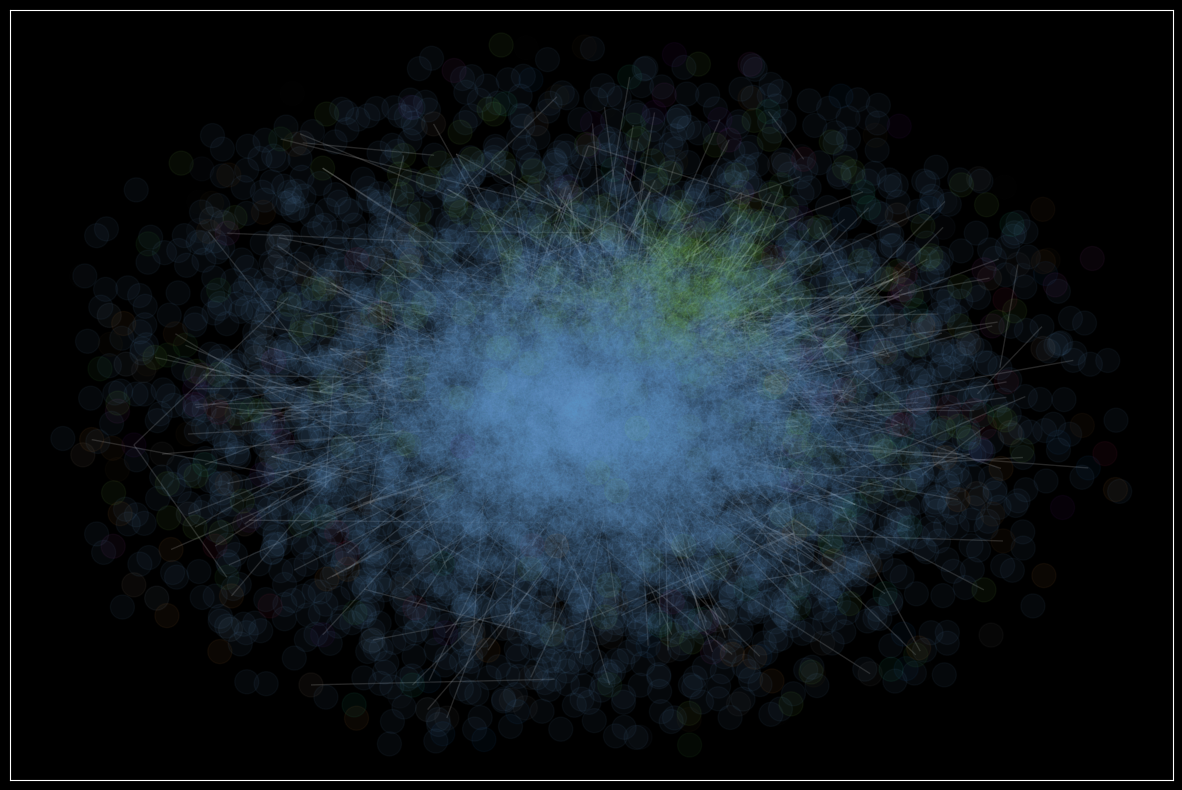

In [45]:
draw_communities(G,label_propagation_communities)

## Fluid Communities
Asynchronous Fluid Communities algorithm for community detection.

FluidC together with Label Propagation (LP) are the fastest and most scalable algorithms with a linear computational complexity of O(N).  FluidC identified 10 communities in 759 ms.  However, FluidC has better performance with 0.398 modularity than LP and it doesn't have the tendency to classfy the Network into one big community and many small ones.  

FluidC avoids the creation of monster communities in a non-parametric manner. Due to the spread of density among the
vertices that compose a community, a large community (when compared to the rest of communities in the graph) will only be able to keep its size and expand by having a favourable topology (i.e., having lots of intra-community edges which make up for its lower density).

FluidC Paper: https://arxiv.org/pdf/1703.09307.pdf

In [78]:
%%time
# 10 communities
asyn_fluidc_communities = sorted(community.asyn_fluidc(G,10), key=len, reverse=True)
communities_stat(asyn_fluidc_communities)

number of communities: 10
average size of communities: 712.6
size of the biggest community: 945
Total number of nodes in the network: 7126
modularity: 0.39809360751591544

CPU times: user 789 ms, sys: 5.56 ms, total: 795 ms
Wall time: 795 ms


In [92]:
%%time
# 100 communities
asyn_fluidc_communities = sorted(community.asyn_fluidc(G,100), key=len, reverse=True)
communities_stat(asyn_fluidc_communities)

number of communities: 100
average size of communities: 71.26
size of the biggest community: 131
Total number of nodes in the network: 7126
modularity: 0.30623093950443575

CPU times: user 558 ms, sys: 19.4 ms, total: 577 ms
Wall time: 576 ms


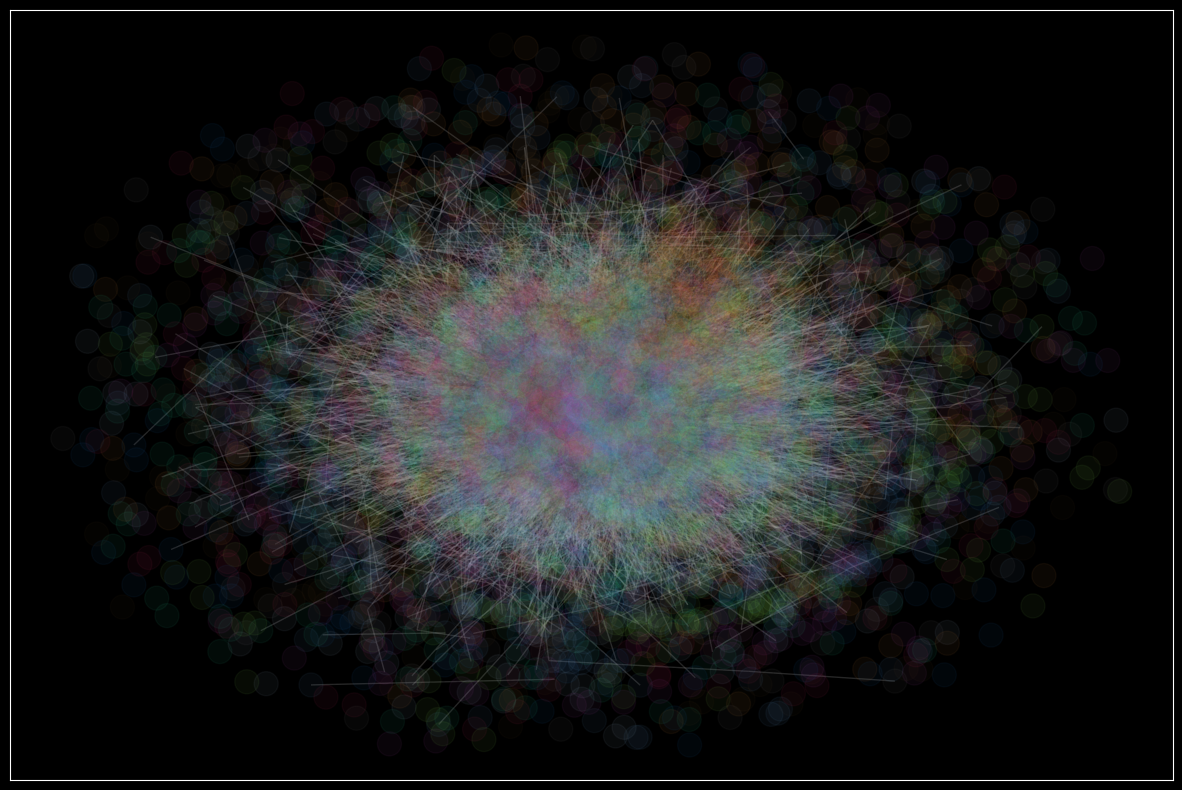

In [46]:
draw_communities(G,asyn_fluidc_communities)

## Measuring partitions

In [77]:
print(f"modularity kernighan_lin_bisection_communities: {community.modularity(G,kernighan_lin_bisection_communities)}")
print(f"modularity greedy_modularity_communities: {community.modularity(G,greedy_modularity_communities)}")
print(f"modularity asyn_lpa_communities: {community.modularity(G,asyn_lpa_communities)}")
print(f"modularity label_propagation_communities: {community.modularity(G,label_propagation_communities)}")
print(f"modularity louvain_communities: {community.modularity(G,louvain_communities.communities)}")
print(f"modularity asyn_fluidc_communities: {community.modularity(G,asyn_fluidc_communities)}")


modularity kernighan_lin_bisection_communities: 0.00813519011307598
modularity greedy_modularity_communities: 0.4194352773646462
modularity asyn_lpa_communities: 0.11271385751963052
modularity label_propagation_communities: 0.11346012912724766
modularity louvain_communities: 0.45325161616627774
modularity asyn_fluidc_communities: 0.3831893540926878


## Other Potentials Topics to discuss
### Compare Leiden's improvements over Louvain
### Walktrap: random walks in the network


## Reference:

https://graphsandnetworks.com/community-detection-using-networkx/

https://networkx.org/documentation/stable/reference/algorithms/community.html

https://arxiv.org/pdf/1703.09307.pdf

https://link.springer.com/article/10.1007/s00607-021-01027-4

https://www.researchgate.net/publication/351058899_LPA-MNI_An_Improved_Label_Propagation_Algorithm_Based_on_Modularity_and_Node_Importance_for_Community_Detection

Leiden/infomap
https://theses.liacs.nl/pdf/2019-2020-VerweijGeerten.pdf